# Home Credit Default Risk Estimation

В този notebook ще разгледаме конкурса за машинно обучение на Home Credit за калкулиране на риск от неизпълнение на заеми, който преди това се проведе на Kaggle. Целта на конкурса беше да се използват исторически (реални) данни за заявления за кредити, за да се предскаже дали даден кандидат ще бъде в състояние да изплати кредита. Това е стандартна задача за класификация с надзор:

* __Наблюдавана__: Лейбълите са включени в данните за обучение и целта е да се обучи модел, който да се научи да прогнозира label-и въз основа на feature-ите
* __Класификация__: Лейбъла е бинарна променлива, 0 (ще изплати кредита навреме), 1 (ще има затруднения при изплащането на кредита)


# Данни

Данните са предоставени от [Home Credit](http://www.homecredit.net/about-us.aspx), услуга, посветена на предоставянето на кредити (заеми) на населението без банкови сметки. Прогнозирането дали даден клиент ще изплати заема си или ще има затруднения е от критично значение за бизнеса, и Home Credit организира този конкурс в Kaggle (и споделиха данните си), за да види какви модели може да разработи общността за машинно обучение.

Има 7 различни източника на данни:

* application_train/application_test: основните данни за обучение и тестване с информация за всяка заявка за заем в Home Credit. Всеки заем има свой собствен ред и се идентифицира с характеристиката `SK_ID_CURR`. Данните за обучението на заявките се предоставят с `TARGET`, който показва 0: заемът е изплатен или 1: заемът не е изплатен.
* bureau: данни за предишни кредити на клиента от други финансови институции. Всеки предишен кредит има свой собствен ред в bureau, но един кредит в данните за заявката може да има няколко предишни кредита.
* bureau_balance: месечни данни за предишните кредити в bureau. Всеки ред е един месец от предишен кредит, а един предишен кредит може да има няколко реда, по един за всеки месец от продължителността на кредита.
* previous_application: предишни заявки за кредити в Home Credit на клиенти, които имат кредити в данните на заявката. Всеки текущ кредит в данните на заявката може да има няколко предишни кредита. Всяка предишна заявка има един ред и се идентифицира с характеристиката `SK_ID_PREV`.
* POS_CASH_BALANCE: месечни данни за предишни кредити на място или в брой, които клиентите са имали при Home Credit. Всеки ред е един месец от предишен кредит на място или в брой, а един предишен кредит може да има много редове.
* credit_card_balance: месечни данни за предишни кредитни карти, които клиентите са имали в Home Credit. Всеки ред е един месец от салдото на кредитната карта, а една кредитна карта може да има много редове.
* installments_payment: история на плащанията за предишни заеми в Home Credit. Има един ред за всяко извършено плащане и един ред за всяко пропуснато плащане.

Тази диаграма показва как всички данни са свързани:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Освен това, разполагаме с дефинициите на всички колони (в `HomeCredit_columns_description.csv`) и пример за очаквания файл за подаване.

## Метрика: ROC AUC

След като разберем данните (прочитането на [описанията на колоните](https://www.kaggle.com/c/home-credit-default-risk/data) помага изключително много), трябва да разберем метриката, по която се оценява нашето представяне. В този случай това е обща класификационна метрика, известна като [Receiver Operating Characteristic Area Under the Curve (ROC AUC, понякога наричана и AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

ROC AUC може да звучи плашещо, но всъщност е сравнително просто, след като разберем двете отделни концепции. Кривата [Reciever Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) представя графично съотношението между истинските положителни (true positives) резултати и фалшивите положителни (false positives) резултати:

![image](https://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

Една линия на графиката показва кривата за един модел, а движението по линията показва промяната на прага, използван за класифициране на положителен случай. Прагът започва от 0 в горния десен ъгъл и стига до 1 в долния ляв ъгъл. Крива, която е вляво и над друга крива, показва по-добър модел. Например, синият модел е по-добър от червения модел, който е по-добър от черната диагонална линия, която показва наивен модел на случайно предположение.

[Площта под кривата (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) се обяснява сама по себе си с името си! Това е просто площта под ROC кривата. (Това е интегралът на кривата.) Тази метрика е между 0 и 1, като по-добрият модел получава по-висок резултат. Модел, който просто предполага на случаен принцип, ще има ROC AUC от 0,5.

Когато измерваме класификатор според ROC AUC, ние не генерираме прогнози 0 или 1, а по-скоро вероятност между 0 и 1. Това може да бъде объркващо, защото обикновено ни харесваме да мислим в термини на точност, но когато се сблъскаме с проблеми с небалансирани класове (ще видим, че това е случаят), точността не е най-добрият показател. Например, ако искам да създадем модел, който да открива терориристи с точност 99,9999%, просто бихме създали модел, който предсказва, че нито един човек не е терорист. Ясно е, че това няма да бъде ефективно (припомнянето (recall) ще бъде нула) и заради това използваме по-усъвършенствани показатели като ROC AUC или [F1 score](https://en.wikipedia.org/wiki/F1_score), за да отразим по-точно ефективността на класификатора. Модел с висок ROC AUC също ще има висока точност, но [ROC AUC е по-добро представяне на ефективността на модела.](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy)

Сега, когато знаем контекста на данните, които използваме, и метриката, която трябва да максимизираме, можем да преминем към изследването на данните.


## Импорти

Използваме типичен набор от инструменти за наука за данните: `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [81]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Четене на данни

Първо, можем да изброим всички налични файлове с данни. Общо има 9 файла: 1 основен файл за обучение (с цел), 1 основен файл за тестване (без цел), 1 файл с пример за подаване и 6 други файла, съдържащи допълнителна информация за всеки заем.

In [82]:
# List files available
print(os.listdir("../input/"))

['application_test.csv', 'application_train.csv']


In [83]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Данните за обучението съдържат 307511 наблюдения (всяко от които е отделен заем) и 122 характеристики (променливи), включително `TARGET` (етикетът, който искаме да предскажем).

In [84]:
# Testing data features
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Тестовият набор е значително по-малък и няма колона „TARGET“.

# Изследователски анализ на данни

Изследователският анализ на данни (Exploratory Data Analysis - EDA) е отворен процес, при който изчисляваме статистически данни и създаваме графики, за да открием тенденции, аномалии, модели или взаимоотношения в данните. Целта на EDA е да разберем какво ни разкриват данните. Обикновено започва с общ преглед, след което се фокусира върху конкретни области, когато открием интересни аспекти на данните. Резултатите могат да бъдат интересни сами по себе си или да се използват за вземане на решения при моделирането, например като ни помогнат да решим кои функции да използваме.

## Проучваме дистрибуцията на TARGET колоната

Целта е това, което трябва да предвидим: или 0, ако заемът е бил изплатен навреме, или 1, което показва, че клиентът е имал затруднения с плащането. Първо можем да проучим броя на заемите, попадащи във всяка категория.

In [85]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

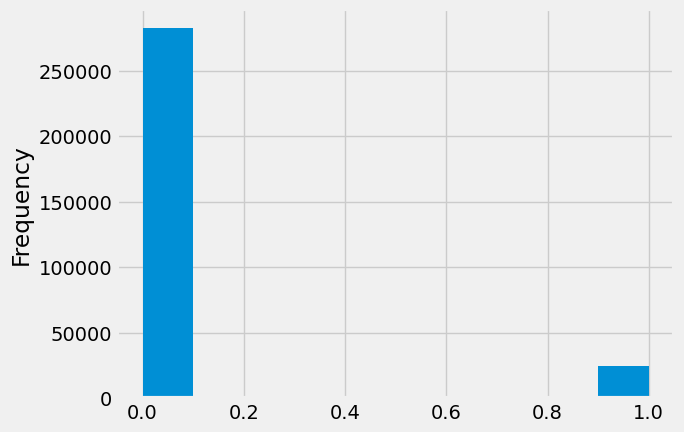

In [86]:
app_train['TARGET'].astype(int).plot.hist();

От тази информация виждаме, че това е [_проблем с небалансирани класове_](http://www.chioka.in/class-imbalance-problem/). Има много повече кредити, които са били изплатени навреме, отколкото кредити, които не са били изплатени. Щом преминем към по-сложни модели за машинно обучение, можем да [претеглим класовете](http://xgboost.readthedocs.io/en/latest/parameter.html) според тяхното представяне в данните, за да отразим този дисбаланс.

## Проверка на липсващи стойности

След това можем да разгледаме броя и процента на липсващите стойности във всяка колона.

In [87]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [88]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


Когато дойде време да изградим нашите модели за машинно обучение, ще трябва да попълним тези липсващи стойности (известно като импутация). В по-късна работа ще използваме модели като XGBoost, които могат [да обработват липсващи стойности без необходимост от импутация](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Друга потенциална възможност е да премахнем колоните с висок процент липсващи стойности, въпреки че е невъзможно да знаем предварително дали тези колони ще бъдат полезни за нашия модел. Затова засега ще запазим всички колони.

## Типове колони

Нека разгледаме броя колони за всеки тип данни. `int64` и `float64` са числови променливи ([които могат да бъдат дискретни или непрекъснати](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). Колоните `object` съдържат низове и са  [категорични характеристики.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) .

In [89]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

Сега нека разгледаме броя на уникалните записи във всяка от колоните „object“ (категорични).

In [90]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Повечето от категоричните променливи имат относително малък брой уникални записи. Трябва да намерим начин да се справим с тези категорични променливи!

## Кодиране на категориални променливи

Преди да продължим, трябва да се справим с досадните категорични променливи.  За съжаление, нашият модел за машинно обучение не може да се справи с категорични променливи (с изключение на някои модели като [LightGBM](http://lightgbm.readthedocs.io/en/latest/Features.html)). Ето защо трябва да намерим начин да кодираме (представим) тези променливи като числа, преди да ги предадем на модела. Има два основни начина за извършване на този процес:

* Кодиране на етикети: присвояване на цяло число на всяка уникална категория в категориална променлива. Не се създават нови колони. Пример е показан по-долу

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* Еднократно кодиране: създайте нова колона за всяка уникална категория в категориална променлива. Всяко наблюдение получава 1 в колоната за съответната категория и 0 във всички други нови колони.

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

Проблемът с кодирането на етикети е, че то дава на категориите произволен ред. Стойността, присвоена на всяка от категориите, е случайна и не отразява никакъв присъщ аспект на категорията. В горния пример програмистът получава 4, а научният работник по данни – 1, но ако повторим същия процес, етикетите могат да бъдат обърнати или напълно различни. Действителното присвояване на целите числа е произволно. Следователно, когато извършваме кодиране на етикети, моделът може да използва относителната стойност на характеристиката (например програмист = 4 и учен по данни = 1), за да присвои тегла, което не е това, което искаме. Ако имаме само две уникални стойности за категориална променлива (като Мъж/Жена), тогава кодирането на етикети е подходящо, но за повече от 2 уникални категории, еднократното кодиране е по-безопасният вариант.

Има някои спорове относно относителните предимства на тези подходи, а някои модели могат да се справят без проблеми с категорични променливи, кодирани с етикети. [Ето една добра дискусия в Stack Overflow](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). Мисля (и това е само лично мнение), че за категорични променливи с много класове еднократното кодиране е най-безопасният подход, защото не налага произволни стойности на категориите. Единственият недостатък на еднократното кодиране е, че броят на характеристиките (измеренията на данните) може да се увеличи значително при категорични променливи с много категории. За да се справим с това, можем да извършим еднократно кодиране.

Тук ще използваме Label Encoding за всички категориални променливи с само 2 категории и One-Hot Encoding за всички категориални променливи с повече от 2 категории.

### Кодиране на етикети и еднократно кодиране

Нека приложим описаната по-горе политика: за всяка категориална променлива (`dtype == object`) с 2 уникални категории ще използваме кодиране на етикети, а за всяка категориална променлива с повече от 2 уникални категории ще използваме еднократно кодиране.

За кодиране на етикети използваме Scikit-Learn `LabelEncoder`, а за еднократно кодиране – функцията pandas `get_dummies(df)`.

In [91]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [92]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Съгласуване на данните за обучение и тестване

Данните за обучение и тестване трябва да имат еднакви характеристики (колони). Еднократното кодиране е създало повече колони в данните за обучение, защото имаше някои категорични променливи с категории, които не са представени в данните за тестване. За да премахнем колоните в данните за обучение, които не са в данните за тестване, трябва да „съгласуваме“ рамките с данни. Първо извличаме целевата колона от данните за обучение (тъй като тя не е в данните за тестване, но трябва да запазим тази информация). Когато извършваме съгласуването, трябва да се уверим, че сме задали „axis = 1“, за да съгласуваме рамките с данни въз основа на колоните, а не на редовете!

In [93]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Наборът от данни за обучение и тестване вече има същите характеристики, които са необходими за машинно обучение. Броят на характеристиките е нараснал значително благодарение на еднократното кодиране.

## Назад към експлоративен анализ на данни

### Аномалии

Един проблем, за който винаги трябва да внимаваме при извършването на EDA, са аномалиите в данните. Те могат да се дължат на грешки при въвеждането на числа, грешки в измервателните уреди или да са валидни, но екстремни измервания. Един от начините да подкрепим аномалиите количествено е да разгледаме статистиката на дадена колона, като използваме метода `describe`. Числата в колоната `DAYS_BIRTH` са отрицателни, защото са записани спрямо текущата заявка за заем. За да видим тези статистики в години, можем да ги умножим по -1 и да ги разделим на броя дни в годината:

In [94]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Тези възрасти изглеждат разумни. Няма изключения за възрастта нито в горния, нито в долния край. А как стои въпросът с дните на заетост?

In [95]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Това не изглежда правилно! Максималната стойност (освен че е положителна) е около 1000 години!

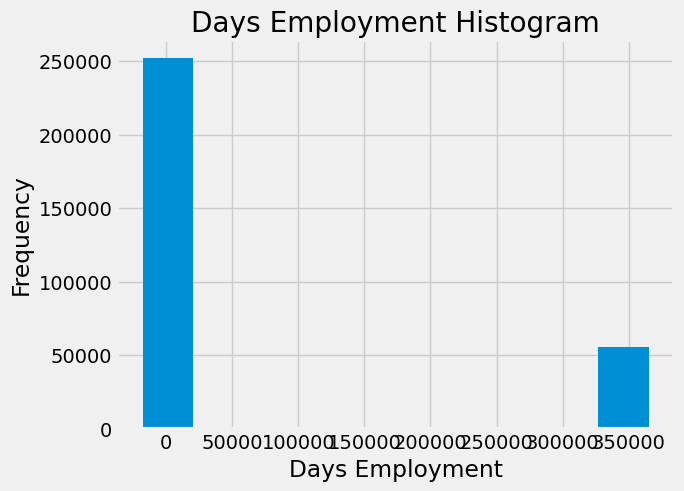

In [96]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Просто от любопитство, нека разделим аномалните клиенти на подгрупи и да видим дали те имат по-високи или по-ниски нива на просрочване в сравнение с останалите клиенти.

In [97]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Това е изключително интересно! Оказва се, че аномалиите имат по-ниска степен на неизпълнение.

Обработката на аномалиите зависи от конкретната ситуация, без да има установени правила. Един от най-безопасните подходи е просто да зададе аномалиите като липсващи стойности и след това да ги попълним (използвайки импутация) преди машинно обучение. В този случай, тъй като всички аномалии имат една и съща стойност, искаме да ги попълним със същата стойност, в случай че всички тези заеми имат нещо общо. Аномалните стойности изглежда имат някакво значение, затова искаме да информираме модела за машинно обучение, ако действително сме попълнили тези стойности. Като решение ще попълним аномалните стойности с нечисло (`np.nan`) и след това ще създадем нова булева колона, която показва дали стойността е аномална или не.


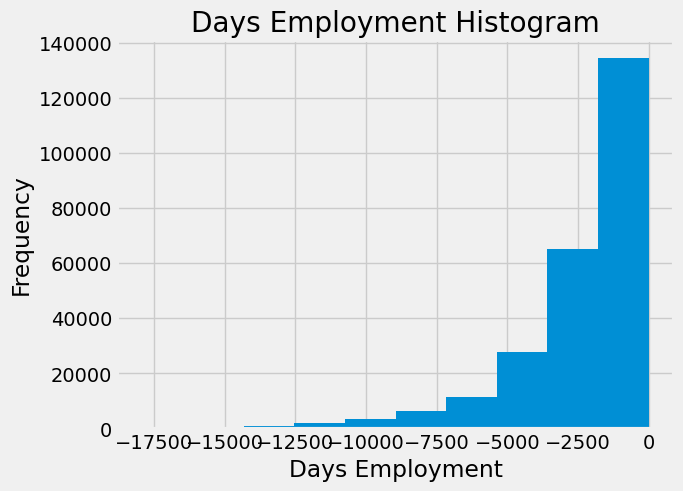

In [98]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Дистрибуцията изглежда много по-съвместима с това, което бихме очаквали, и също така сме създали нова колона, за да покажем на модела, че тези стойности са били първоначално аномални (тъй като ще трябва да попълним nans с някаква стойност, вероятно медианата на колоната). Другите колони с `DAYS` в dataframe изглеждат така, както очакваме, без очевидни изключения.

Много важно е да отбележим, че всичко, което правим с данните за обучение, трябва да направим и с данните за тестване. Нека се уверим, че сме създали новата колона и сме попълнили съществуващата колона с `np.nan` в данните за тестване.

In [99]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Корелации

След като разгледахме категоричните променливи и изключенията, нека продължим с EDA. Един от начините да се опитаме да разберем данните е да потърсим корелации между характеристиките и целта. Можем да изчислим коефициента на корелация на Пиърсън между всяка променлива и целта, като използваме метода `.corr` на dataframe.

Коефициентът на корелация не е най-добрият метод за представяне на „релевантността“ на дадена характеристика, но ни дава представа за възможните взаимоотношения в данните. Някои [общи интерпретации на абсолютната стойност на коефициента на корелация](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) са:


* .00-.19 „много слаба“
*  .20-.39 „слаба“
*  .40-.59 „умерена“
*  .60-.79 „силна“
* .80-1.0 „много силна“

In [100]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Нека разгледаме някои от по-значимите корелации: `DAYS_BIRTH` е най-положителната корелация. (с изключение на `TARGET`, защото корелацията на една променлива със самата себе си винаги е 1!) Според документацията, `DAYS_BIRTH` е възрастта в дни на клиента към момента на отпускане на заема в отрицателни дни (по каквато и да е причина!). Корелацията е положителна, но стойността на тази характеристика всъщност е отрицателна, което означава, че с напредването на възрастта на клиента вероятността той да просрочи заема си намалява (т.е. целта == 0). Това е малко объркващо, затова ще вземем абсолютната стойност на характеристиката и тогава корелацията ще бъде отрицателна.

### Ефектът на Възрастта върху Изплащането на заем

In [101]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

np.float64(-0.07823930830982709)

С напредването на възрастта на клиента се наблюдава отрицателна линейна зависимост с целта, което означава, че с напредването на възрастта клиентите са по-склонни да изплащат заемите си навреме.

Нека започнем да разглеждаме тази променлива. Първо, можем да направим хистограма на възрастта. Ще поставим ос х в години, за да направим графиката малко по-разбираема.

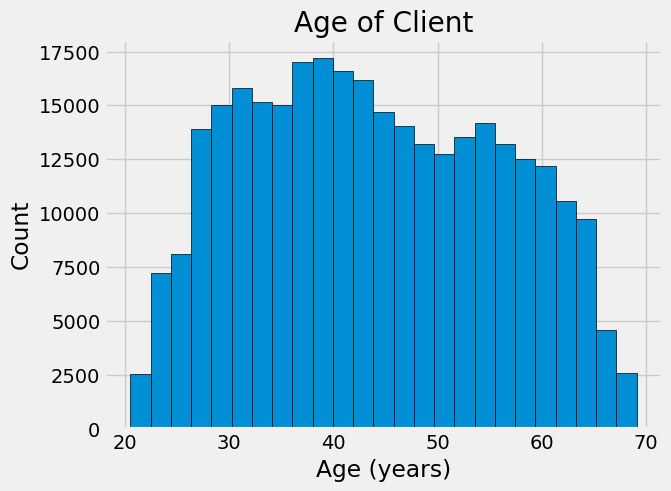

In [102]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

Само по себе си разпределението на възрастта не ни дава много информация, освен че няма изключения, тъй като всички възрасти са разумни. За да визуализираме ефекта на възрастта върху целта, ще направим [графика за оценка на плътността на ядрото](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE), оцветена според стойността на целта. [Графиката за оценка на плътността на ядрото показва разпределението на една променлива](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) и може да се разглежда като изгладена хистограма (създава се чрез изчисляване на ядро, обикновено гаусово, във всяка точка от данните и след това усредняване на всички индивидуални ядра, за да се получи една гладка крива). За тази графика ще използваме seaborn `kdeplot`.

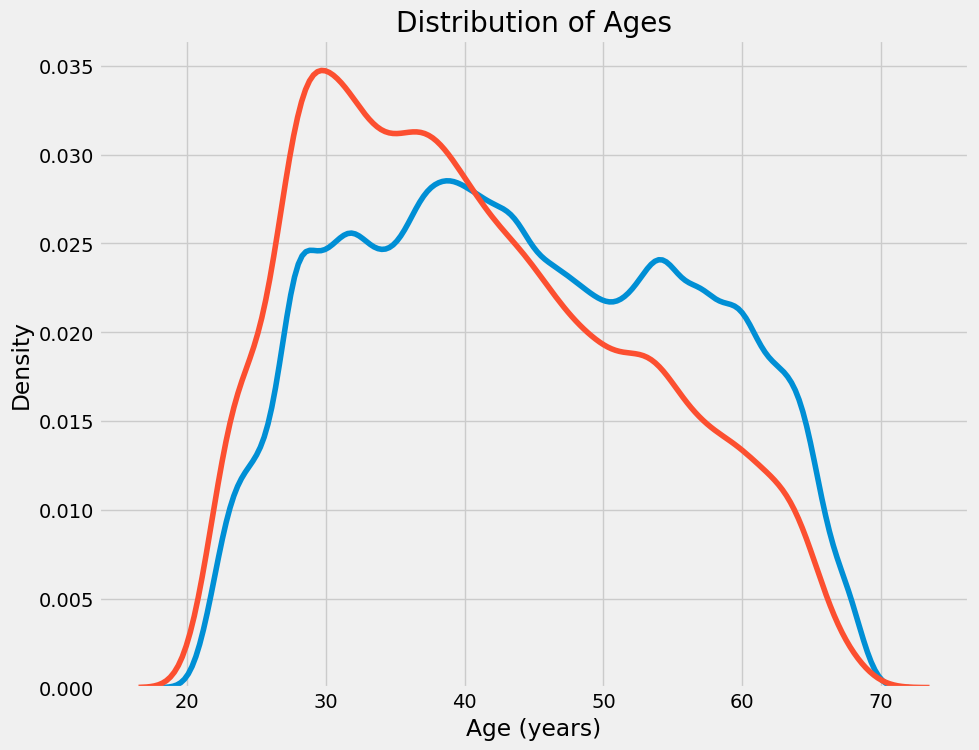

In [103]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

Кривата на целта == 1 се изкривява към по-младата част от диапазона. Въпреки че това не е значителна корелация (корелационен коефициент -0,07), тази променлива вероятно ще бъде полезна в модел за машинно обучение, защото влияе на целта. Нека разгледаме тази връзка по друг начин: средна невъзможност за погасяване на кредити по възрастови групи.

За да създадем тази графика, първо „разделяме“ възрастовата категория на групи от по 5 години. След това за всяка група изчисляваме средната стойност на целта, която ни показва съотношението на невъзстановените кредити във всяка възрастова категория.

In [104]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [105]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


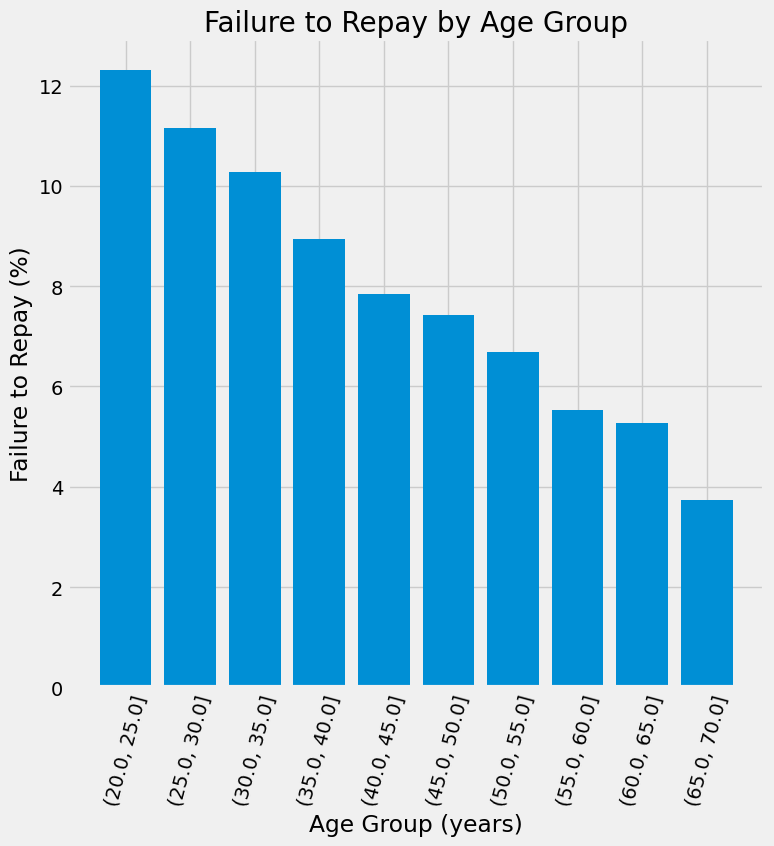

In [106]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Налице е ясна тенденция: по-младите кандидати са по-склонни да не изплащат кредита! Процентът на неизплатени кредити е над 10% за трите най-млади възрастови групи и под 5% за най-възрастната възрастова група.

Това е информация, която може да бъде използвана директно от банката: тъй като по-младите клиенти са по-малко склонни да изплатят заема, може би трябва да им се предостави повече насоки или съвети за финансово планиране. Това не означава, че банката трябва да дискриминира по-младите клиенти, но би било разумно да се вземат предпазни мерки, за да се помогне на по-младите клиенти да плащат навреме.

### Външни източници

Трите променливи с най-силна отрицателна корелация с целта са `EXT_SOURCE_1`, `EXT_SOURCE_2` и `EXT_SOURCE_3`.
Според документацията тези характеристики представляват „нормализирана оценка от външен източник на данни“. Не съм сигурен какво точно означава това, но може да е нещо като кумулативна кредитна оценка, изготвена въз основа на множество източници на данни.

Нека разгледаме тези променливи.

Първо, можем да покажем корелациите на характеристиките `EXT_SOURCE` с целта и помежду си.

In [107]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


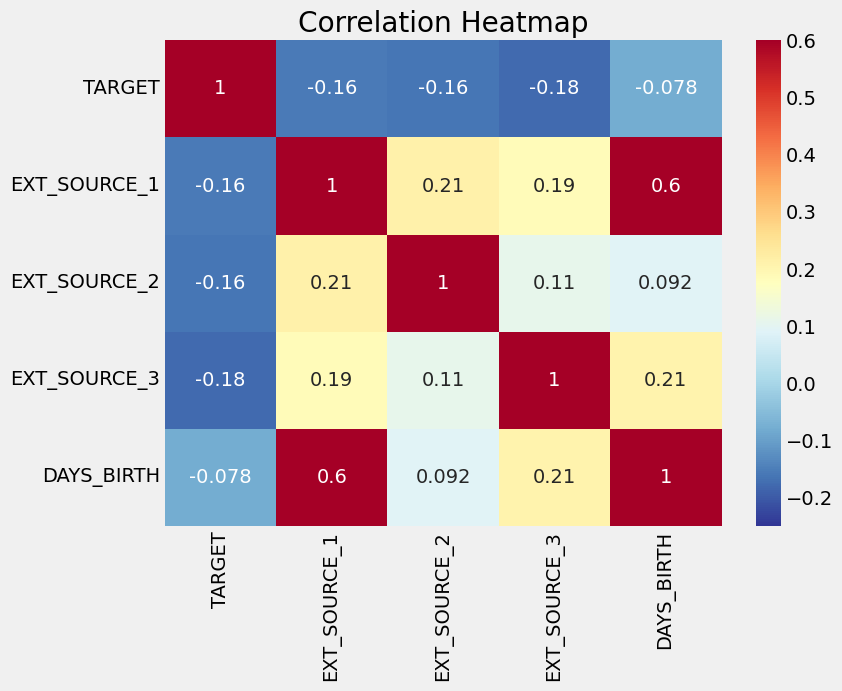

In [108]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

И трите характеристики `EXT_SOURCE` имат отрицателна корелация с целта, което показва, че с увеличаването на стойността на `EXT_SOURCE`, клиентът е по-склонен да изплати заема. Можем също да видим, че `DAYS_BIRTH` е положително корелиран с `EXT_SOURCE_1`, което показва, че може би един от факторите в тази оценка е възрастта на клиента.

След това можем да разгледаме разпределението на всяка от тези характеристики, оцветени според стойността на целта. Това ще ни позволи да визуализираме ефекта на тази променлива върху целта.

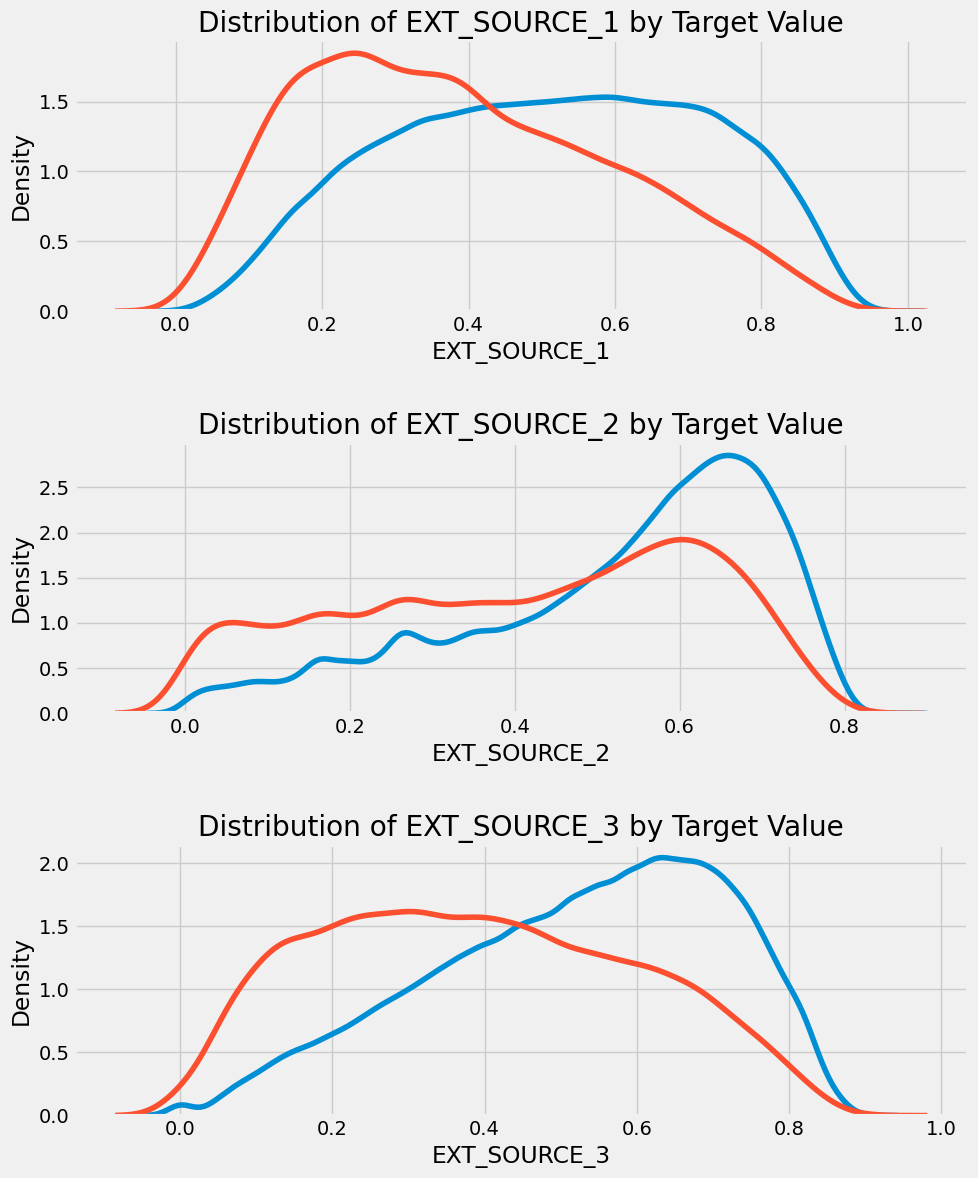

In [109]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` показва най-голямата разлика между стойностите на целта. Можем ясно да видим, че тази характеристика има някаква връзка с вероятността кандидатът да изплати заема. Връзката не е много силна (всъщност всички те се [смятат за много слаби](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), но тези променливи все пак ще бъдат полезни за модел за машинно обучение, който да предскаже дали кандидатът ще изплати заема навреме.

## Диаграма на двойки

Като окончателна проучвателна диаграма можем да направим диаграма на двойки от променливите `EXT_SOURCE` и `DAYS_BIRTH`. [Двойката графики](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) е чудесен инструмент за изследване, защото ни позволява да видим взаимоотношенията между множество двойки променливи, както и разпределенията на единични променливи. Тук използваме библиотеката за визуализация seaborn и функцията PairGrid, за да създадем диаграма на двойки с разпръснати точки в горния триъгълник, хистограми по диагонала и 2D ядрени плътностни диаграми и корелационни коефициенти в долния триъгълник.

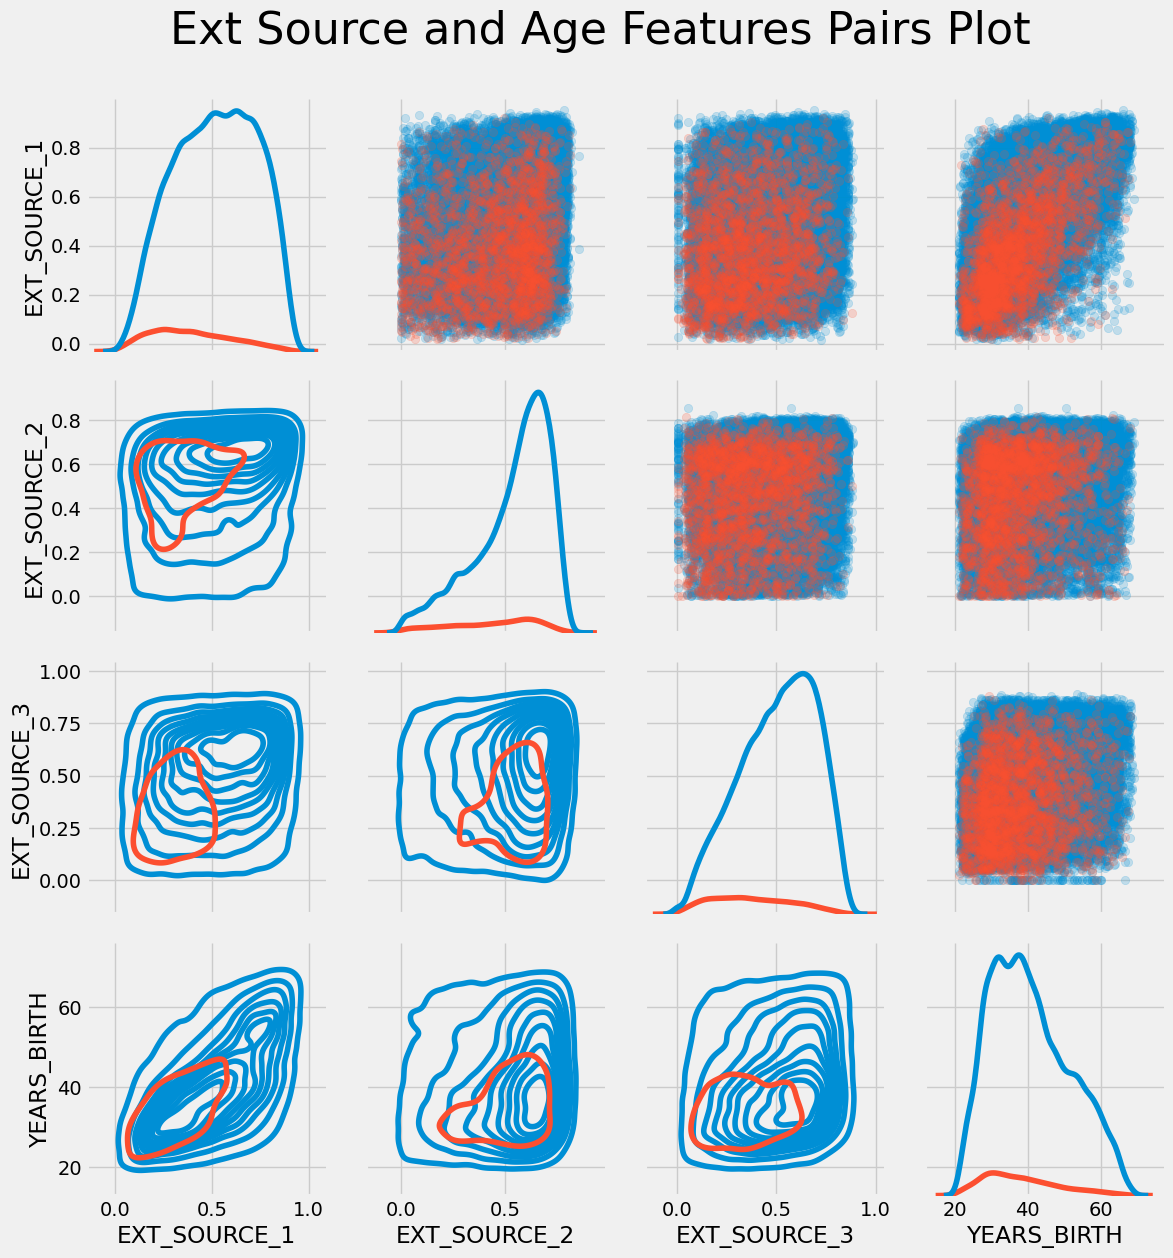

In [110]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, height = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

В тази графика червеният цвят обозначава невъзстановени кредити, а синият – възстановени кредити. Можем да видим различните взаимоотношения в данните. Изглежда, че съществува умерена положителна линейна зависимост между `EXT_SOURCE_1` и `DAYS_BIRTH` (или еквивалентно `YEARS_BIRTH`), което показва, че тази характеристика може да взема предвид възрастта на клиента.

# Инженеринг на характеристики (Feature engineering)

Инженерингът на характеристики се отнася до общ процес и може да включва както конструиране на характеристики: добавяне на нови характеристики от съществуващите данни, така и избор на характеристики: избор само на най-важните характеристики или други методи за намаляване на измеренията. Има много техники, които можем да използваме както за създаване, така и за избор на характеристики.

Ще опитаме следните два прости метода за конструиране на характеристики:
* Полиномни характеристики
* Характеристики на домейн знания

## Полиномни характеристики (Polynomial features)

Един прост метод за създаване на характеристики се нарича [полиномни характеристики](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). При този метод създаваме характеристики, които са степени на съществуващи характеристики, както и функции на една или повече съществуващи характеристики. Например можем да създадем променливи `EXT_SOURCE_1^2` и `EXT_SOURCE_2^2`, а също и променливи като `EXT_SOURCE_1` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2^2`, `EXT_SOURCE_1^2` x   `EXT_SOURCE_2^2` и т.н. Тези характеристики, които са комбинация от множество индивидуални променливи, се наричат [термини за взаимодействие (interaction terms)](https://en.wikipedia.org/wiki/Interaction_(statistics)), защото те  улавят взаимодействията между променливите. С други думи, докато две променливи сами по себе си  може да не оказват силно влияние върху целта (target), комбинирането им в една променлива, която е тяхна функция, може да покаже по-силна връзка. [Термините за взаимодействие се използват често в статистическите модели](https://www.theanalysisfactor.com/interpreting-interactions-in-regression/), за да уловят ефектите от множество променливи, но не се използват толкова често в машинното обучение. Въпреки това, може да пробваме да видим дали могат да помогнат на нашия модел да предскаже дали даден клиент ще изплати заем. 

Джейк Вандерплас пише за [полиномните характеристики в своята книга „Python for Data Science“](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html) за тези, които искат повече информация.

В следния код създаваме полиномни характеристики, използвайки променливите `EXT_SOURCE` и `DAYS_BIRTH`. [Scikit-Learn има полезен клас, наречен `PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), който създава полиномите и термините за взаимодействие до определена степен. Можем да използваме степен 3, за да видим резултатите (когато създаваме полиномни характеристики, искаме да избегнем използването на прекалено висока степен, както защото броят на характеристиките се променя експоненциално със степента, така и защото можем да се сблъскаме с [проблеми с overfitting](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)).

In [111]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [112]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


Това създава значителен брой нови характеристики. За да получим имената им, трябва да използваме метода `get_feature_names`.

In [113]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

Има 35 нови характеристики, от които някои са просто степени на входните характеристики, а други са техни произведения и функции. Сега можем да проверим дали някоя от тези нови характеристики е в корелация с целта.

In [114]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Няколко от новите променливи имат по-голяма (в смисъл на абсолютна стойност) корелация с целта, отколкото оригиналните характеристики. Когато създаваме модели за машинно обучение, можем да опитаме с и без тези характеристики, за да определим дали те действително помагат на модела да се учи.

Ще добавим тези характеристики към копие от данните за обучение и тестване и след това ще оценим моделите с и без характеристиките. Много пъти в машинното обучение единственият начин да разберем дали даден подход ще проработи, е да го изпробваме! 

In [115]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


## Признаци, базирани на знания в областта (Domain Knowledge Features)

Можем да създадем няколко характеристики, които се опитват да уловят това, което според нас може да е важно, за да преценим дали даден клиент ще просрочи плащането по заема си. Тук ще използвам пет характеристики, вдъхновени от [този скрипт](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) на Aguiar:

* `CREDIT_INCOME_PERCENT`: процентът на кредитната сума спрямо дохода на клиента
* `ANNUITY_INCOME_PERCENT`: процентът на годишната вноска по кредита спрямо дохода на клиента
* `CREDIT_TERM`:  продължителността на плащането в месеци
* `DAYS_EMPLOYED_PERCENT`: процентът на отработените дни спрямо възрастта на клиента

In [116]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [117]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

#### Визуализиране на новите променливи

Трябва да изследваме тези __Domain Knowledge__ променливи визуално в графика. За всички тях ще направим една и съща KDE графика, оцветена според стойността на `TARGET`.

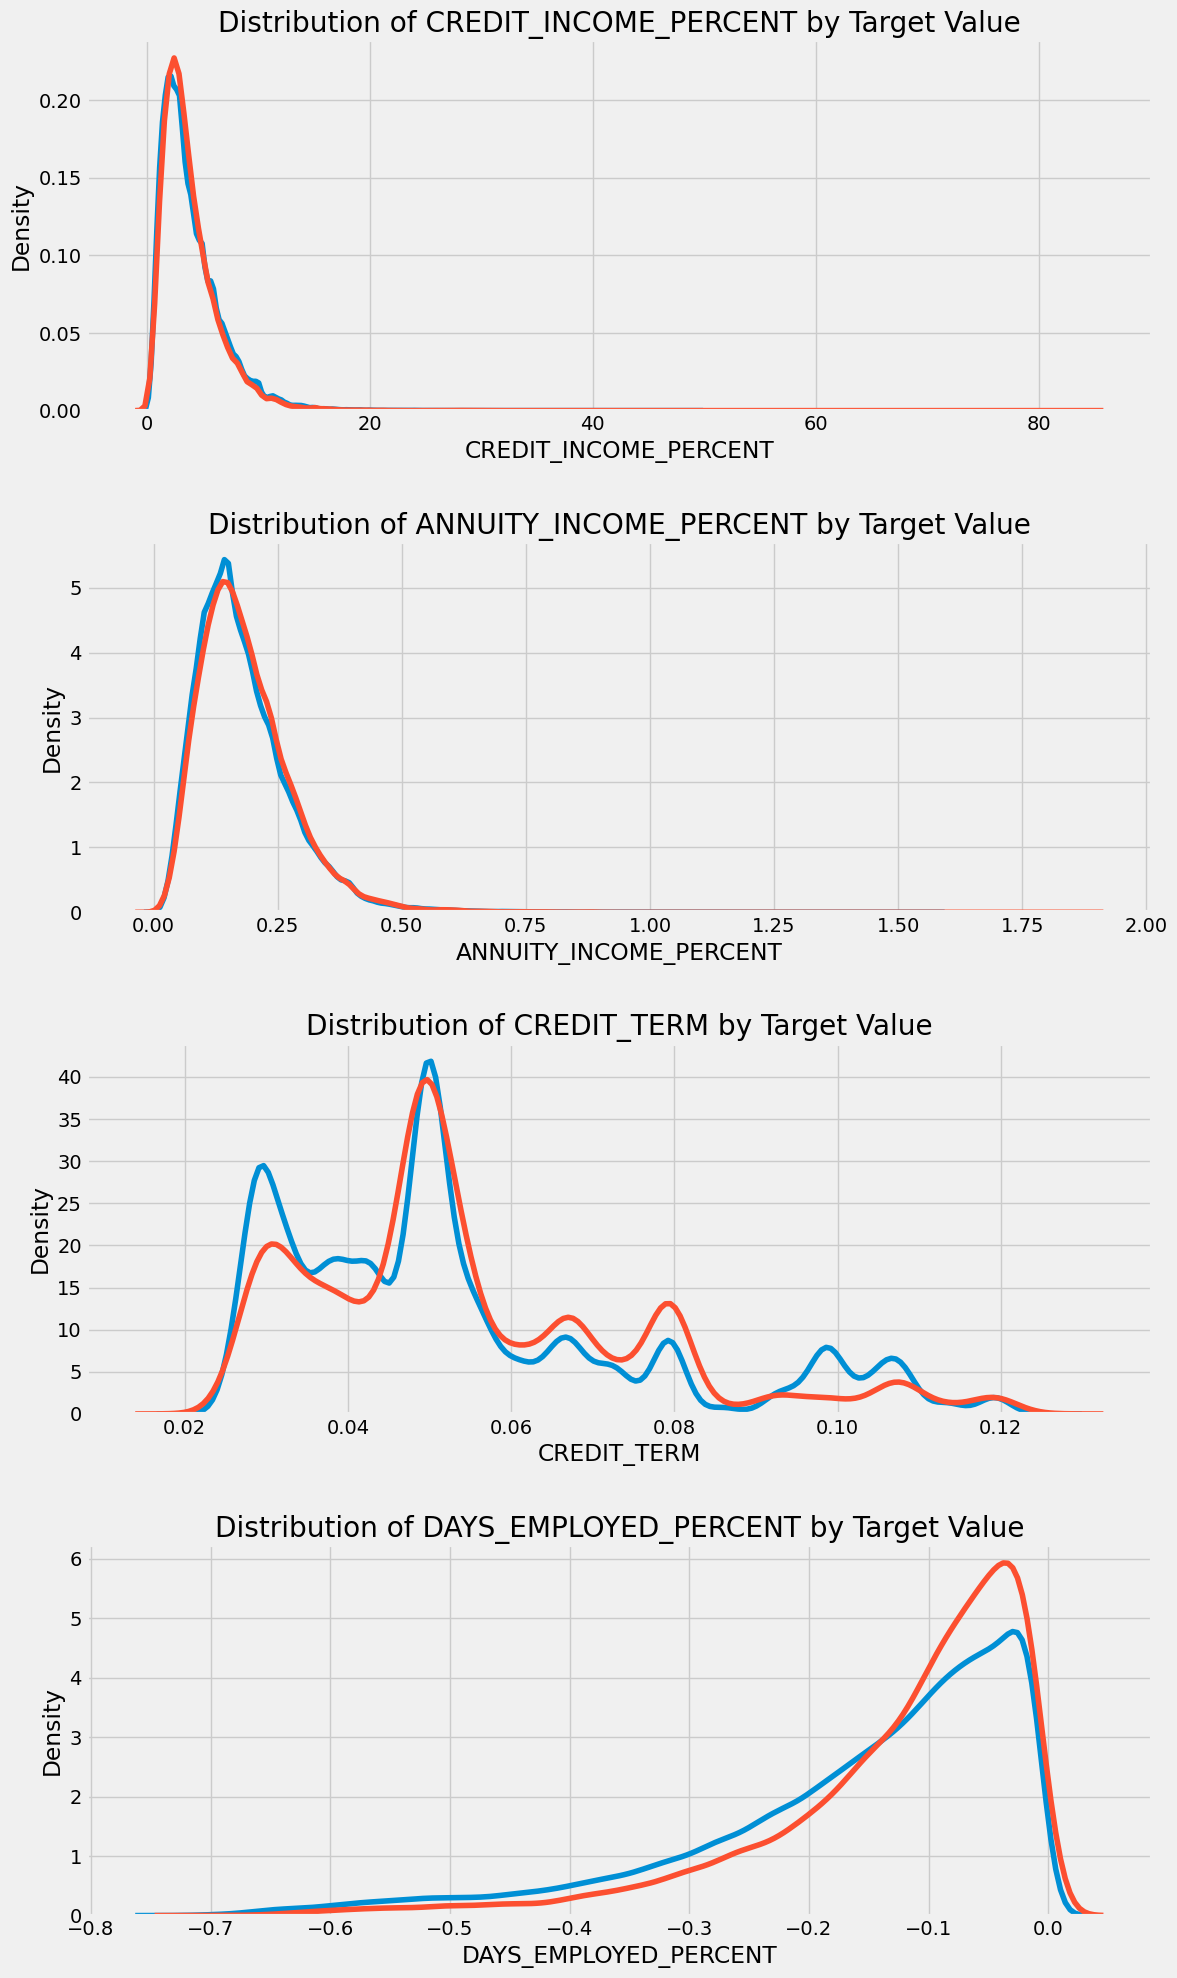

In [118]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Трудно е да се каже предварително дали тези нови характеристики ще бъдат полезни. Единственият начин да разберем със сигурност е да ги изпробваме!

# Базов Модел (Baseline)

За един наивен базов модел бихме могли да предположим една и съща стойност за всички примери в тестовия набор. От нас се иска да предвидим вероятността за непогасяване на заема, така че ако сме напълно несигурни, бихме предположили 0.5 за всички наблюдения в тестовия набор.

Това ще ни донесе резултат от 0.5 за Площ под кривата на работната характеристика на приемника (AUC ROC) ([случайното предполагане при задача за класификация винаги дава резултат 0.5](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)).

Тъй като вече знаем какъв резултат ще получим, всъщност няма нужда да правим наивно базово предположение. Нека използваме малко по-сложен модел за нашия действителен базов модел: Логистична регресия (Logistic Regression).

## Приложение на логистичната регресия

Тук ще се съсредоточим върху прилагането на модела, а не върху обяснението на подробностите.

За да получим базовия модел, ще използваме всички характеристики след кодиране на категоричните променливи. Ще обработим предварително данните, като попълним липсващите стойности (импутация, imputation) и нормализираме диапазона на характеристиките (мащабиране на характеристиките, feature scaling). Следният код изпълнява и двете стъпки на предварителната обработка.

In [119]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


За първия ни модел ще използваме [`LogisticRegression`от Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Единствената промяна, която ще направим в настройките на модела по подразбиране, е да намалим [параметъра за регуларизация (regularization parameter)](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), C, който контролира степента на overfitting (по-ниска стойност трябва да намали overfitting). Това ще ни даде малко по-добри резултати от подразбиращия се `LogisticRegression`, но все пак ще постави ниска летва за всички бъдещи модели.

Тук използваме познатия синтаксис за моделиране на Scikit-Learn: първо създаваме модела, след това го обучаваме с помощта на `.fit` и накрая правим прогнози за тестовите данни с помощта на `.predict_proba` (не забравяйте, че искаме вероятности, а не 0 или 1).

In [120]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.0001
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`

Сега, след като моделът е обучен, можем да го използваме за правене на прогнози. Искаме да предскажем вероятносттта заемът да не бъде изплатен, затова използваме метода `predict.proba` на модела. Той връща масив m x 2, където m е броят на наблюденията. Първата колона е вероятността целта да е 0, а втората колона е вероятността целта да е 1 (така че за един ред двете колони трябва да дават сума 1). Искаме вероятността заемът да не бъде изплатен, затова ще изберем втората колона.

Следващият код прави прогнозите и избира правилната колона.

In [121]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

Прогнозите трябва да бъдат във формата, показана във файла `sample_submission.csv`, където има само две колони: `SK_ID_CURR` и `TARGET`. Ще създадем таблица с данни в този формат от тестовия набор и прогнозите, наречена `submit`. 

In [122]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.078558
1,100005,0.137864
2,100013,0.082147
3,100028,0.081013
4,100038,0.132471


Прогнозите представляват вероятност между 0 и 1, че заемът няма да бъде изплатен. Ако използваме тези прогнози за класифициране на кандидатите, можем да определим праг на вероятност, при който да преценим, че даден заем е рисков. 

In [123]:
# Save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index = False)

## Подобрен модел: Random Forest

За да се опитаме да подобрим слабото представяне на базовия ни модел, можем да променим алгоритъма. Нека опитаме да използваме Random Forest върху същите тренировъчни данни, за да видим как това се отразява на представянето. Random Forest е много по-мощен модел, особено когато използваме стотици дървета. Ще използваме 100 дървета в Random Forest.

In [124]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [125]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


In [126]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

Тези прогнози ще бъдат достъпни и когато изпълним целия notebook.

### Правене на прогнози, използвайки инженерни характеристики (Engineered Features)

Единственият начин да проверим дали полиномните характеристики (Polynomial features) и познанията за областта (Domain features) са подобрили модела е да обучим и тестваме модел въз основа на тези характеристики! След това можем да сравним неговото представяне с това на модела без тези характеристики, за да оценим ефекта от feature engineering-а.

In [127]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = SimpleImputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [128]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [129]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)

Този модел се представя точно като онзи без инженерните характеристики. Предвид тези резултати, изглежда, че в този случай нашата конструкция на характеристики не е помогнала. 

#### Тестване на характеристиките на домейна (Domain features)

Сега можем да тестваме характеристиките на домейна, които създадохме ръчно.

In [130]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = SimpleImputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


In [131]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

При подаването му резултатът е 0.679 (резултатът на стария е 0.678), което вероятно показва, че инженерните характеристики не помагат в този модел (въпреки че помагат в модела Gradient Boosting в края на notebook-а).

## Интерпретация на модела: Значимост на характеристиките

Като прост метод за определяне кои променливи са най-релевантни, можем да разгледаме значимостта на характеристиките на random forest. Предвид корелациите, които видяхме в експлоративния анализ на данните, можем да очакваме, че най-важните характеристики са `EXT_SOURCE` и `DAYS_BIRTH`. Можем да използваме значимостта на тези характеристики като метод за редуциране на измеренията (dimensionality reduction) в бъдещата си работа.

In [132]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

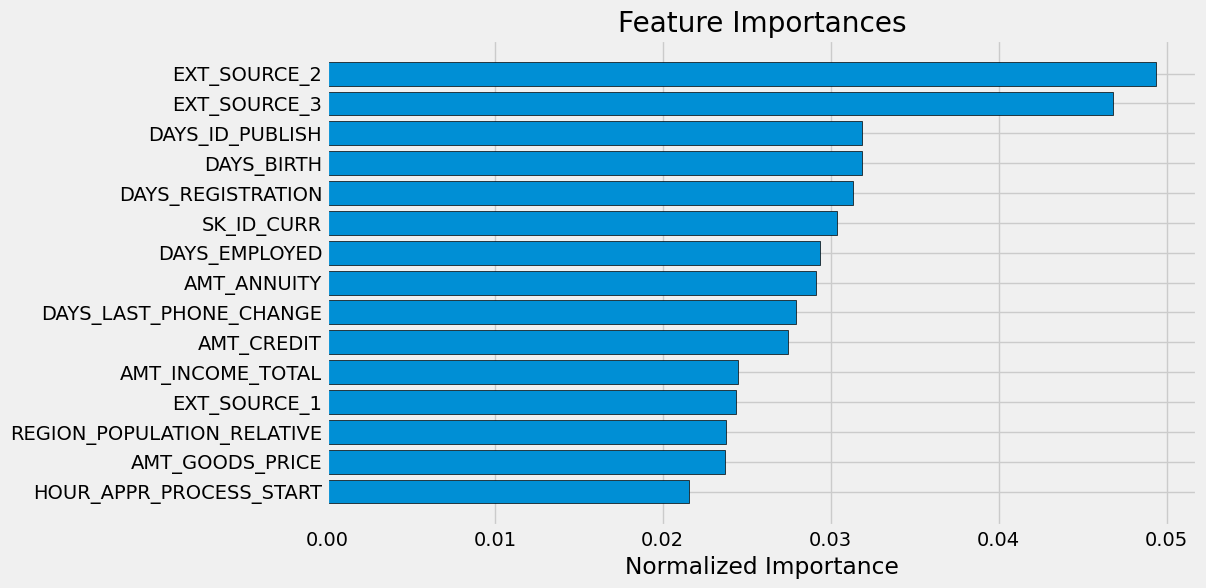

In [133]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

Както се очакваше, най-важните характеристики са тези, свързани с `EXT_SOURCE` и `DAYS_BIRTH`. Виждаме, че има само няколко характеристики със значителна важност за модела, което предполага, че можем да премахнем много от характеристиките, без да се понижи производителността (а дори може да се наблюдава повишение на производителността). Важността на характеристиките не е най-сложният метод за интерпретиране на модел или за намаляване на измеренията, но ни позволява да започнем да разбираме кои фактори взема предвид моделът ни, когато прави прогнози.

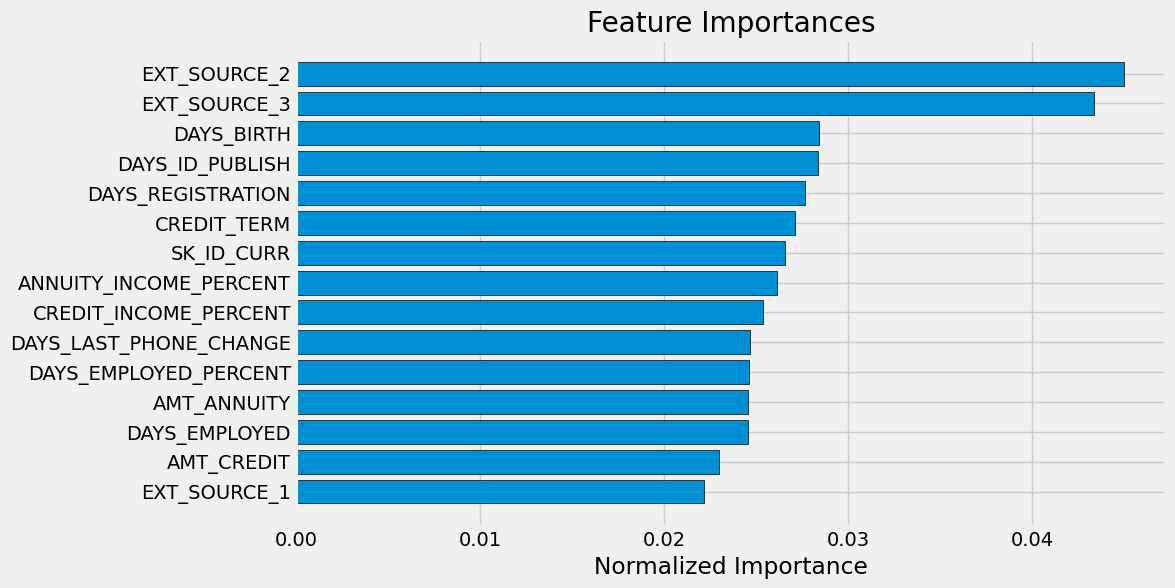

In [134]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

Виждаме, че и четирите ни ръчно разработени характеристики са се класирали в топ 15 на най-важните! Това трябва да ни даде увереност, че нашите познания в областта (Domain knowledge) са били поне частично правилни.

# Заключение

В този notebook видяхме как да се справим с тази конкретна задача за credit risk assessment в Kaggle. Първо се уверихме, че разбираме данните, задачата си и показателите, по които ще бъдат оценявани нашите предложения. След това извършихме доста прост анализ на данните (Exploratory Data Analysis), за да се опитаме да идентифицираме взаимоотношения, тенденции или аномалии, които могат да помогнат за моделирането ни. По време на процеса извършихме необходимите стъпки за предварителна обработка, като кодиране на категорични променливи (encoding categorical variables), импутиране на липсващи стойности (imputing missing values) и мащабиране на характеристики до определен диапазон (scaling features to a range). След това създадохме нови характеристики от съществуващите данни, за да видим дали това може да помогне на нашия модел. 

След като сме направили проучването на данните, подготовката на данните и feature engineering, ние имплементирахме базов модел, който може да бъде подобрен. След това създадохме втори, малко по-сложен модел, за да подобрим първия си резултат. Проведохме и експеримент, за да определим ефекта от добавянето на engineering variables. 

Следвахме общия план на [проект за машинно обучение](https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420): 

1. Разбиране на проблема и данните
2. Почистване и форматиране на данните (в по-голямата си част първоначалните данни вече бяха сравнително чисти и форматирани)
3. Изследователски анализ на данните (EDA)
4. Базов модел
5. Подобрен модел
6. Интерпретация на модела

# Light Gradient Boosting Machine

Сега можем да направим крачка напред и да използваме истински модел за машинно обучение: [Light Gradient Boosting Machine](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/), използваща [библиотеката LightGBM](http://lightgbm. readthedocs.io/en/latest/Quick-Start.html)! Light Gradient Boosting Machine е бил водещ модел за обучение на структурирани набори от данни (особено в Kaggle).

In [140]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        callbacks = [early_stopping(stopping_rounds=100), log_evaluation(period=200)]

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  callbacks=callbacks)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [141]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 239)
Testing Data Shape:  (48744, 239)
[LightGBM] [Info] Number of positive: 19919, number of negative: 226089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11473
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798723	train's binary_logloss: 0.547797	valid's auc: 0.755039	valid's binary_logloss: 0.563266
[400]	train's auc: 0.82838	train's binary_logloss: 0.518334	valid's auc: 0.755107	valid's binary_logloss: 0.545575
Early stopping, best iteration is:
[315]	train's auc: 0.816657	train's binary_logloss: 0.530116	valid's auc: 0.755215	valid's binary_loglos

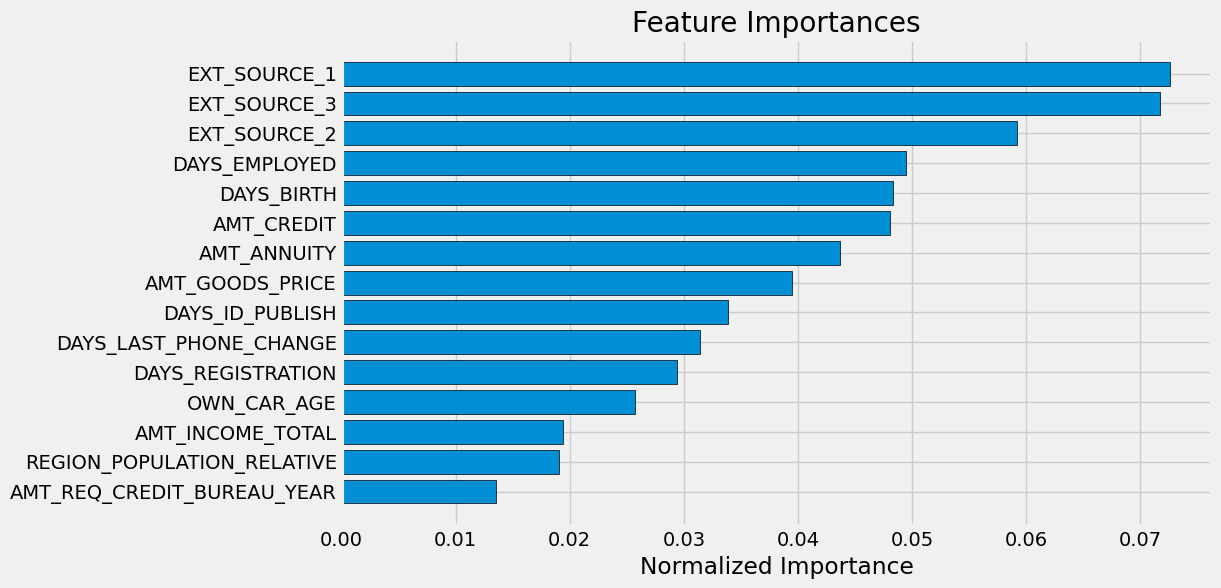

In [142]:
fi_sorted = plot_feature_importances(fi)

In [143]:
submission.to_csv('baseline_lgb.csv', index = False)

Този модел е оценен с 0.735 в Kaggle.

In [144]:
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

Training Data Shape:  (307511, 243)
Testing Data Shape:  (48744, 243)
[LightGBM] [Info] Number of positive: 19919, number of negative: 226089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12493
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.804779	train's binary_logloss: 0.541283	valid's auc: 0.762511	valid's binary_logloss: 0.557227
Early stopping, best iteration is:
[268]	train's auc: 0.815523	train's binary_logloss: 0.530413	valid's auc: 0.763069	valid's binary_logloss: 0.550276
[LightGBM] [Info] Number of positive: 19863, number of negative: 226146
[LightGBM] [Info] Auto-choosing

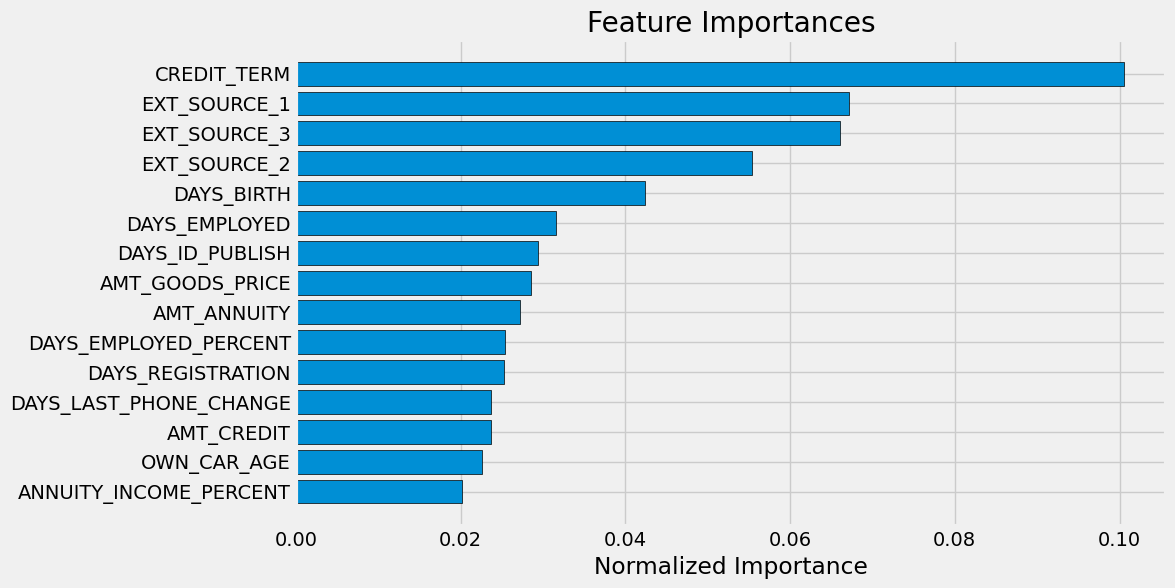

In [145]:
fi_sorted = plot_feature_importances(fi_domain)

Отново виждаме, че някои от нашите характеристики се оказват най-важни.

In [146]:
submission_domain.to_csv('baseline_lgb_domain_features.csv', index = False)

Този модел е оценен с 0.754 в Kaggle, показвайки, че domain feature-ите подобряват представянето! [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) е критично в решаването на тази задача, както и на много други!